# Day 10
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian,

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 1
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [3]:
trainData = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 0.970s 


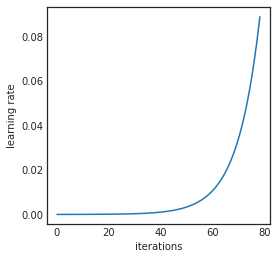

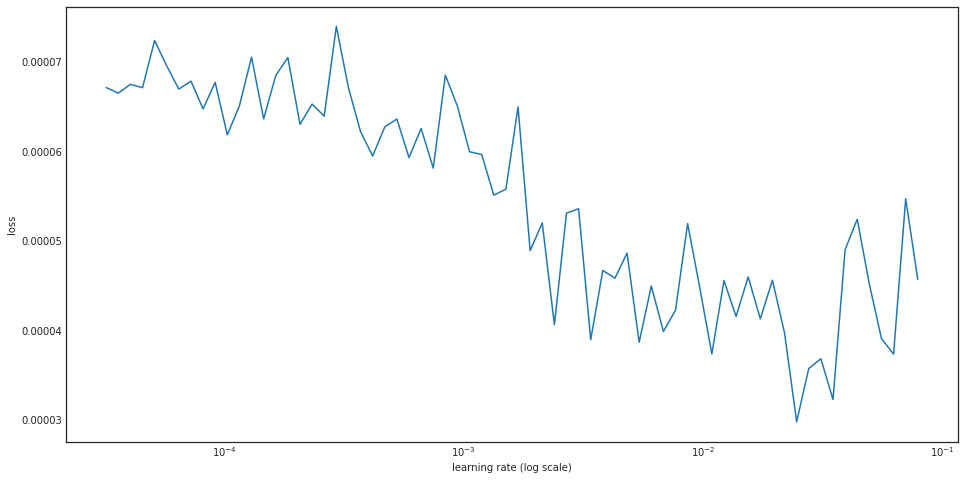

______________________________________



In [4]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [5]:
compileArgs['lr'] = 1e-3

## Train classifier

In [6]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, reduxDecay=True, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 4.23337132812e-05
2 New best found: 3.80989200852e-05
3 New best found: 3.70813704306e-05
4 New best found: 3.64137330489e-05
5 New best found: 3.52519201873e-05
6 New best found: 3.48519164955e-05
7 New best found: 3.47471587032e-05
9 New best found: 3.43078349337e-05
10 New best found: 3.42950752114e-05
11 New best found: 3.40640674413e-05
12 New best found: 3.37856618998e-05
13 New best found: 3.35968466531e-05
14 New best found: 3.34915186105e-05
15 New best found: 3.34831827235e-05
19 New best found: 3.33312492312e-05
22 New best found: 3.29488045364e-05
23 New best found: 3.29325654304e-05
24 New best found: 3.29213046061e-05
26 New best found: 3.27624306201e-05
27 New best found: 3.26684657438e-05
31 New best found: 3.26665452405e-05
40 New best found: 3.25472630148e-05
44 New best found: 3.25158933756e-05
46 New best found: 3.24183312542e-05
49 New best f

KeyboardInterrupt: 

## Construct ensemble

In [7]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [8]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 0 with loss = 3.1850099291083325e-05


## Response on val data

In [83]:
class RotationBatch(BatchYielder):
    def __init__(self, header, datafile=None, augMult=8, inputPipe=None, trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.augmented = True
        self.augMult = augMult
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        self.inputPipe = inputPipe
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    @staticmethod
    def rotate(inData):
        vectors = [x[:-3] for x in inData.columns if '_px' in x]
        for vector in vectors:
            if 'jet_leading' in vector:
                cut = inData.PRI_jet_num >= 0.9
                inData.loc[cut, vector + '_px'] = inData.loc[cut, vector + '_px']*np.cos(inData.loc[cut, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[cut, 'aug_angle'])
                inData.loc[cut, vector + '_py'] = inData.loc[cut, vector + '_py']*np.cos(inData.loc[cut, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[cut, 'aug_angle'])
            elif 'jet_subleading' in vector:
                cut = inData.PRI_jet_num >= 1.9
                inData.loc[cut, vector + '_px'] = inData.loc[cut, vector + '_px']*np.cos(inData.loc[cut, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[cut, 'aug_angle'])
                inData.loc[cut, vector + '_py'] = inData.loc[cut, vector + '_py']*np.cos(inData.loc[cut, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[cut, 'aug_angle'])
            else:
                inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
                inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
                
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])

        if isinstance(self.inputPipe, types.NoneType):
            inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        else:
            inputs = pandas.DataFrame(self.inputPipe.inverse_transform(np.array(datafile['fold_' + index + '/inputs'])), columns=self.header)            
        inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
        self.rotate(inputs)
        if isinstance(self.inputPipe, types.NoneType):
            inputs = inputs[self.header].values
        else:
            inputs = inputPipe.transform(inputs[self.header].values)
        
        return {'inputs':inputs,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
        
        if isinstance(self.inputPipe, types.NoneType):
            inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        else:
            inputs = pandas.DataFrame(self.inputPipe.inverse_transform(np.array(datafile['fold_' + index + '/inputs'])), columns=self.header)            
        if augIndex > 0:
            inputs['aug_angle'] = np.linspace(0, 2*np.pi, self.augMult+1)[augIndex]
        else:
            inputs['aug_angle'] = 0.0
        self.rotate(inputs)
        if isinstance(self.inputPipe, types.NoneType):
            inputs = inputs[self.header].values
        else:
            inputs = inputPipe.transform(inputs[self.header].values)
            
        return {'inputs':inputs,
                'targets':targets,
                'weights':weights}

In [84]:
inputs = pandas.DataFrame(inputPipe.inverse_transform(getFeature('inputs', h5py.File(dirLoc + 'val.hdf5', "r+"), ravel=False)), columns=classTrainFeatures)

In [56]:
inputs[['PRI_jet_num']].head()

,PRI_jet_num
0,2.000000e+00
1,-9.918213e-10
2,-9.918213e-10
3,-9.918213e-10
4,1.000000e+00


In [85]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [86]:
valData = RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe, augMult=8)

In [87]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

0        True
1       False
2       False
3       False
4        True
5       False
6       False
7       False
8        True
9       False
10      False
11       True
12      False
13       True
14       True
15      False
16       True
17       True
18      False
19       True
20       True
21       True
22       True
23       True
24       True
25      False
26       True
27       True
28      False
29      False
        ...  
4970     True
4971     True
4972    False
4973    False
4974     True
4975     True
4976     True
4977     True
4978    False
4979     True
4980    False
4981     True
4982     True
4983    False
4984    False
4985    False
4986     True
4987     True
4988    False
4989     True
4990     True
4991     True
4992     True
4993    False
4994    False
4995    False
4996     True
4997     True
4998     True
4999     True
Name: PRI_jet_num, Length: 5000, dtype: bool
0        True
1       False
2       False
3       False
4       False
5       False
6       False
7  

0        True
1       False
2       False
3       False
4        True
5       False
6       False
7       False
8        True
9       False
10      False
11       True
12      False
13       True
14       True
15      False
16       True
17       True
18      False
19       True
20       True
21       True
22       True
23       True
24       True
25      False
26       True
27       True
28      False
29      False
        ...  
4970     True
4971     True
4972    False
4973    False
4974     True
4975     True
4976     True
4977     True
4978    False
4979     True
4980    False
4981     True
4982     True
4983    False
4984    False
4985    False
4986     True
4987     True
4988    False
4989     True
4990     True
4991     True
4992     True
4993    False
4994    False
4995    False
4996     True
4997     True
4998     True
4999     True
Name: PRI_jet_num, Length: 5000, dtype: bool
0        True
1       False
2       False
3       False
4       False
5       False
6       False
7  

0        True
1       False
2        True
3        True
4        True
5       False
6        True
7        True
8       False
9        True
10      False
11       True
12       True
13       True
14      False
15       True
16      False
17      False
18       True
19      False
20       True
21       True
22       True
23       True
24      False
25      False
26       True
27       True
28       True
29      False
        ...  
4970     True
4971    False
4972     True
4973     True
4974     True
4975    False
4976     True
4977    False
4978    False
4979     True
4980    False
4981     True
4982    False
4983    False
4984     True
4985     True
4986    False
4987     True
4988     True
4989    False
4990     True
4991     True
4992     True
4993     True
4994    False
4995     True
4996     True
4997    False
4998    False
4999    False
Name: PRI_jet_num, Length: 5000, dtype: bool
0        True
1       False
2       False
3        True
4        True
5       False
6        True
7  

0        True
1       False
2        True
3        True
4        True
5        True
6       False
7        True
8       False
9        True
10      False
11      False
12       True
13      False
14       True
15      False
16      False
17       True
18       True
19       True
20      False
21       True
22      False
23      False
24      False
25       True
26      False
27       True
28       True
29       True
        ...  
4970    False
4971    False
4972     True
4973     True
4974     True
4975    False
4976     True
4977    False
4978    False
4979     True
4980    False
4981    False
4982    False
4983     True
4984    False
4985     True
4986    False
4987     True
4988     True
4989    False
4990     True
4991     True
4992     True
4993     True
4994    False
4995    False
4996     True
4997    False
4998    False
4999    False
Name: PRI_jet_num, Length: 5000, dtype: bool
0        True
1       False
2       False
3        True
4        True
5        True
6       False
7  

0        True
1       False
2       False
3        True
4        True
5        True
6       False
7        True
8        True
9        True
10      False
11      False
12      False
13      False
14       True
15       True
16       True
17      False
18       True
19       True
20      False
21       True
22       True
23       True
24       True
25      False
26      False
27       True
28      False
29      False
        ...  
4970    False
4971     True
4972    False
4973     True
4974    False
4975     True
4976     True
4977     True
4978     True
4979    False
4980     True
4981     True
4982     True
4983     True
4984    False
4985    False
4986     True
4987     True
4988    False
4989     True
4990     True
4991     True
4992    False
4993    False
4994    False
4995     True
4996     True
4997    False
4998     True
4999    False
Name: PRI_jet_num, Length: 5000, dtype: bool
0       False
1       False
2       False
3        True
4       False
5        True
6       False
7  

0        True
1       False
2       False
3        True
4        True
5        True
6       False
7        True
8        True
9        True
10      False
11      False
12      False
13      False
14       True
15       True
16       True
17      False
18       True
19       True
20      False
21       True
22       True
23       True
24       True
25      False
26      False
27       True
28      False
29      False
        ...  
4970    False
4971     True
4972    False
4973     True
4974    False
4975     True
4976     True
4977     True
4978     True
4979    False
4980     True
4981     True
4982     True
4983     True
4984    False
4985    False
4986     True
4987     True
4988    False
4989     True
4990     True
4991     True
4992    False
4993    False
4994    False
4995     True
4996     True
4997    False
4998     True
4999    False
Name: PRI_jet_num, Length: 5000, dtype: bool
0       False
1       False
2       False
3        True
4       False
5        True
6       False
7  

KeyboardInterrupt: 

In [62]:
tPred = np.concatenate(pred, axis=1)

In [63]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [64]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [65]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8 fixed

In [18]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.610388856645386

In [19]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5023802258162954

In [20]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.5396

### Rot 8 fixed no veto

In [66]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.610388856645386

In [67]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5023802258162954

In [68]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.5396

### Rot 8 rand

In [47]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5957051654091701

In [48]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.4884040280744583

In [49]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.52538

### Rot 10 fixed

In [27]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.6074289030760301

In [28]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5026548672566372

In [29]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.53876

### Rot 16 fixed

In [36]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.6079512478235636

In [37]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.502471772963076

In [38]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.53882